<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/newLossesLucia/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b newLossesLucia https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1650 (delta 44), reused 0 (delta 0), pack-reused 1574
Receiving objects: 100% (1650/1650), 1.64 MiB | 1.83 MiB/s, done.
Resolving deltas: 100% (1052/1052), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
exemplars = [None]*100

test_indexes =  []
accs = []

[94 63 74 21 35 56 91 96 87 48]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
At step  0  and at epoch =  0  the loss is =  2.3197169303894043  and accuracy is =  0.2046
At step  0  and at epoch =  1  the loss is =  1.8329956531524658  and accuracy is =  0.2644
At step  0  and at epoch =  2  the loss is =  1.856825351715088  and accuracy is =  0.3584
At step  0  and at epoch =  3  the loss is =  2.282787799835205  and accuracy is =  0.4056
At step  0  and at epoch =  4  the loss is =  1.6454803943634033  and accuracy is =  0.47
At step  0  and at epoch =  5  the loss is =  1.456395983695983

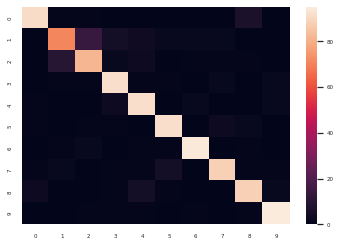

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
        0., 0., 2., 0., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        0., 2., 1., 0., 2., 0., 2., 1., 0., 0.])
At step  10  and at epoch =  0  the loss is =  5.458734512329102  and accuracy is =  0.38671428571428573
At step  10  and at epoch =  1  the loss is =  3.6565945148468018  and accuracy is =  0.5601428571428572
At step  10  and at epoch =  2  the loss is =  3.184109926223755  and accuracy is =  0.6191428571428571
At step  10  and at epoch =  3  the loss is =  3.047912120819092  and accuracy is =  0.6372857142857142
At step  10  and at epoch =  4  the loss is =  2.6539525985717773  and 

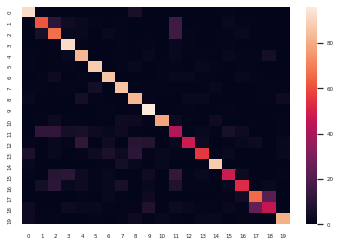

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
        0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 0.,
        1., 0., 3., 0., 0., 0., 2., 1., 2., 3., 0., 0., 1., 0., 2., 1., 0., 0.,
        0., 0., 3., 1., 2., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 3., 0., 1.,
        0., 3., 2., 0., 3., 0., 3., 2., 0., 1.])
At step  20  and at epoch =  0  the loss is =  3.2272772789001465  and accuracy is =  0.3437142857142857
At step  20  and at epoch =  1  the loss is =  2.5965328216552734  and accuracy is =  0.5602857142857143
At step  20  and at epoch =  2  the loss is =  2.8360209465026855  and accuracy is =  0.6228571428571429
At step  20  and at epoch =  3  the loss is =  2.3685054779052734  and accuracy is =  0.6402857142857142
At step  20  and at epoch =  4  the lo

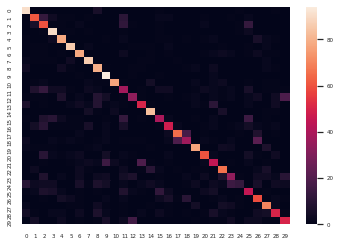

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 4., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
        0., 3., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 4., 1., 0., 3., 0., 0.,
        2., 0., 4., 0., 1., 0., 3., 2., 3., 4., 0., 0., 2., 0., 3., 2., 1., 0.,
        0., 1., 4., 2., 3., 1., 1., 0., 3., 0., 0., 0., 2., 1., 0., 4., 0., 2.,
        0., 4., 3., 0., 4., 0., 4., 3., 1., 2.])
At step  30  and at epoch =  0  the loss is =  2.0112850666046143  and accuracy is =  0.4051355206847361
At step  30  and at epoch =  1  the loss is =  1.866551399230957  and accuracy is =  0.6315263908701855
At step  30  and at epoch =  2  the loss is =  1.7556016445159912  and accuracy is =  0.6616262482168331
At step  30  and at epoch =  3  the loss is =  1.8364893198013306  and accuracy is =  0.6841654778887304
At step  

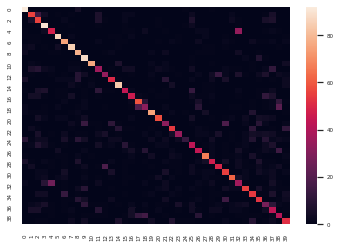

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 5., 4., 3., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 5.,
        1., 4., 0., 3., 0., 2., 0., 0., 0., 1., 0., 0., 5., 2., 0., 4., 0., 0.,
        3., 0., 5., 0., 2., 1., 4., 3., 4., 5., 0., 1., 3., 0., 4., 3., 2., 0.,
        0., 2., 5., 3., 4., 2., 2., 0., 4., 0., 0., 0., 3., 2., 0., 5., 1., 3.,
        1., 5., 4., 1., 5., 0., 5., 4., 2., 3.])
At step  40  and at epoch =  0  the loss is =  2.050645112991333  and accuracy is =  0.37585714285714283
At step  40  and at epoch =  1  the loss is =  2.0835580825805664  and accuracy is =  0.558
At step  40  and at epoch =  2  the loss is =  1.730556607246399  and accuracy is =  0.5885714285714285
At step  40  and at epoch =  3  the loss is =  1.728121042251587  and accuracy is =  0.608285714

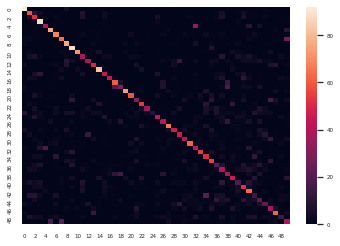

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59 83 43 53 11 86 19 38 30 40 50]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2.,
        0., 1., 0., 6., 5., 4., 3., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 6.,
        2., 5., 1., 4., 1., 3., 0., 1., 0., 2., 0., 0., 6., 3., 1., 5., 0., 1.,
        4., 0., 6., 0., 3., 2., 5., 4., 5., 6., 0., 2., 4., 0., 5., 4., 3., 0.,
        0., 3., 6., 4., 5., 3., 3., 0., 5., 0., 0., 1., 4., 3., 1., 6., 2., 4.,
        2., 6., 5., 2., 6., 0., 6., 5., 3., 4.])
At step  50  and at epoch =  0  the loss is =  2.558119297027588  and accuracy is =  0.396
At step  50  and at epoch =  1  the loss is =  1.6437616348266602  and accuracy is =  0.596
At step  50  and at epoch =  2  the loss is =  2.126654624938965  and accuracy is =  0.6365714285714286
At step  50  and at epoch =  3  the loss is =  1.888561725616455  and accuracy i

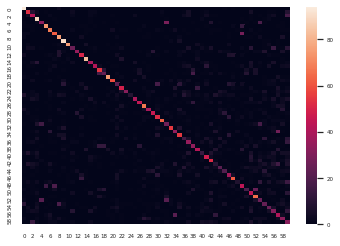

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59 83 43 53 11 86 19 38 30 40 50 57 81 12 95 25 47 34 52 44 72]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 3.,
        0., 2., 0., 7., 6., 5., 4., 1., 0., 0., 0., 0., 2., 0., 3., 0., 1., 7.,
        3., 6., 2., 5., 2., 4., 0., 2., 1., 3., 0., 1., 7., 4., 2., 6., 1., 2.,
        5., 0., 7., 1., 4., 3., 6., 5., 6., 7., 0., 3., 5., 0., 6., 5., 4., 0.,
        1., 4., 7., 5., 6., 4., 4., 0., 6., 1., 0., 2., 5., 4., 2., 7., 3., 5.,
        3., 7., 6., 3., 7., 1., 7., 6., 4., 5.])
At step  60  and at epoch =  0  the loss is =  1.934545874595642  and accuracy is =  0.39928366762177653
At step  60  and at epoch =  1  the loss is =  2.006286144256592  and accuracy is =  0.6200573065902579
At step  60  and at epoch =  2  the loss is =  1.534390926361084  and accuracy is =  0.642406876790831
At step  60  and at epoch

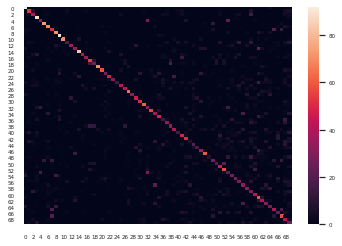

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59 83 43 53 11 86 19 38 30 40 50 57 81 12 95 25 47 34 52 44 72 46 79
 20 28  5 71  8 18 33 15]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 4., 3., 2., 0., 0., 1., 0., 4.,
        1., 3., 1., 8., 7., 6., 5., 2., 0., 0., 1., 0., 3., 0., 4., 1., 2., 8.,
        4., 7., 3., 6., 3., 5., 0., 3., 2., 4., 1., 2., 8., 5., 3., 7., 2., 3.,
        6., 0., 8., 2., 5., 4., 7., 6., 7., 8., 0., 4., 6., 0., 7., 6., 5., 1.,
        2., 5., 8., 6., 7., 5., 5., 1., 7., 2., 0., 3., 6., 5., 3., 8., 4., 6.,
        4., 8., 7., 4., 8., 2., 8., 7., 5., 6.])
At step  70  and at epoch =  0  the loss is =  1.9012507200241089  and accuracy is =  0.41251778093883357
At step  70  and at epoch =  1  the loss is =  1.8788714408874512  and accuracy is =  0.6510668563300143
At step  70  and at epoch =  2  the loss is =  1.447965145111084  and accuracy is =  0.69231863

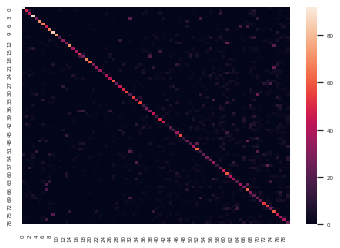

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59 83 43 53 11 86 19 38 30 40 50 57 81 12 95 25 47 34 52 44 72 46 79
 20 28  5 71  8 18 33 15 55 29 64 31 67  7 13 14 42  6]
tensor([0., 0., 0., 0., 0., 2., 1., 1., 2., 0., 5., 4., 3., 1., 1., 2., 0., 5.,
        2., 4., 2., 9., 8., 7., 6., 3., 0., 0., 2., 1., 4., 1., 5., 2., 3., 9.,
        5., 8., 4., 7., 4., 6., 1., 4., 3., 5., 2., 3., 9., 6., 4., 8., 3., 4.,
        7., 1., 9., 3., 6., 5., 8., 7., 8., 9., 1., 5., 7., 1., 8., 7., 6., 2.,
        3., 6., 9., 7., 8., 6., 6., 2., 8., 3., 0., 4., 7., 6., 4., 9., 5., 7.,
        5., 9., 8., 5., 9., 3., 9., 8., 6., 7.])
At step  80  and at epoch =  0  the loss is =  2.280874013900757  and accuracy is =  0.38471428571428573
At step  80  and at epoch =  1  the loss is =  1.8195805549621582  and accuracy is =  0.584
At step  80  and at epoch =  2  the loss is =  1.8048317432403564  and accuracy

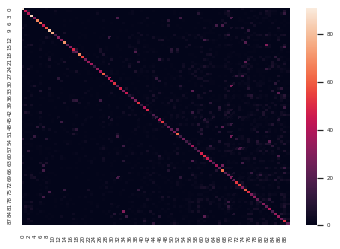

[94 63 74 21 35 56 91 96 87 48 68 80 22 37 60 97 51 62 92 76 75 89 23 99
 39 66 54 69 84 61 85 24 98 41 73 58 78 77 70 49 65 88 36 93 45 10 90 17
 32 59 83 43 53 11 86 19 38 30 40 50 57 81 12 95 25 47 34 52 44 72 46 79
 20 28  5 71  8 18 33 15 55 29 64 31 67  7 13 14 42  6 82  2 27 16 26  3
  4  1  9  0]
tensor([ 1.,  1.,  1.,  1.,  1.,  3.,  2.,  2.,  3.,  1.,  6.,  5.,  4.,  2.,
         2.,  3.,  1.,  6.,  3.,  5.,  3., 10.,  9.,  8.,  7.,  4.,  1.,  1.,
         3.,  2.,  5.,  2.,  6.,  3.,  4., 10.,  6.,  9.,  5.,  8.,  5.,  7.,
         2.,  5.,  4.,  6.,  3.,  4., 10.,  7.,  5.,  9.,  4.,  5.,  8.,  2.,
        10.,  4.,  7.,  6.,  9.,  8.,  9., 10.,  2.,  6.,  8.,  2.,  9.,  8.,
         7.,  3.,  4.,  7., 10.,  8.,  9.,  7.,  7.,  3.,  9.,  4.,  1.,  5.,
         8.,  7.,  5., 10.,  6.,  8.,  6., 10.,  9.,  6., 10.,  4., 10.,  9.,
         7.,  8.])
At step  90  and at epoch =  0  the loss is =  2.8404502868652344  and accuracy is =  0.419054441260745
At step  90  and at epoch

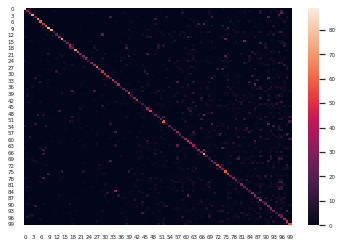

In [10]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer, randomS = True)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
      tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()